# Policy Networks

Enough with all these Values... All of our Q-Learning models that we explored ([DQN](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Deep%20Q-Learning/deep_q_learning.ipynb), [Double DQN](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Double%20Deep-Q%20Learning/double_deep_q_learning.ipynb), [Dueling DQN](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Dueling%20Deep-Q%20Learning/dueling_deep_q_learning.ipynb)) all were solving for fundamentally the same thing:

What is the Value of taking a specific action at a specific state? The *Deep* part of the Deep Q-Learning was just a reparametization of the Q-Table, so instead of a giant table of States and Actions, you just have a Neural Network now. 

But once we had a trained Deep Q-Model what did we do? We needed our **POLICY** which is our end goal. The policy is the learned guidebook (or strategy) that tells us what action to take given the state, and is typically written with the letter $\pi$. With our trained Q-Model we created our policy by:

$$\pi = arg\max_a Q(s,a)$$

We simply picked the action $a$ at a state $s$ that had the highest value!

Well, if our end goal is the Policy anyway, then why not train our Neural Network directly as a Policy network? Forget estimating values, all we care about is what action we should take at a state, so why not just learn that?

Therefore, our Neural Network will directly learn the policy $\pi_\theta(a|s)$ (policy parameterized by $\theta$, rather than first learning $Q_\theta(s,a)$ and then deriving the policy from that!

## Policy Gradient Theorem

**Credit** to Lilian Weng and this [incredible post](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#ppg) on Policy Gradient Methods. Much of what I will do will be close to this (and the [Sutton & Barto, 2017, page 287](http://incompleteideas.net/book/bookdraft2017nov5.pdf) Bible for RL). Also I hope you understood the derivation of the Bellman Equation that we did in our [Introduction to RL](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Based%20Learning/intro_rl_and_policy_iter.ipynb). We will be using pieces of that derivation here as well!

First of all, our goal is still the same. We want to find the policy that maximizes our overall expected return, but we have to go about this a different way. The reward can be written as:

$$J(\theta) = \sum_{s}d_\pi(s)V_\pi(s)$$

### Side Note: Stationary Distribution

What is $d_\pi(s)$? It is known as the stationary distribution, a common property of Markov Chains! Lets first define our Markov Chain via is Transition probability matrix. If we pretend there are only 5 states in our environment, it is a matrix identifying the probability of moving from one state to another:

$$P_{ij} = P(t+1=j|t=i)$$

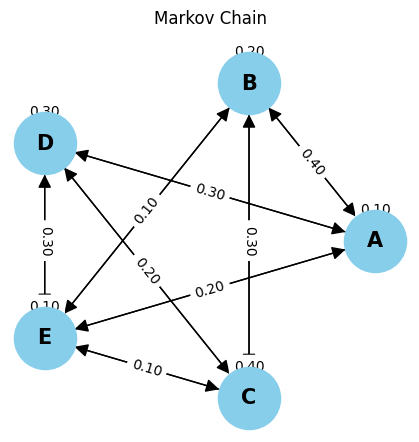

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Video

P = np.array([
    [0.1, 0.6, 0.0, 0.2, 0.1],
    [0.4, 0.2, 0.2, 0.0, 0.2],
    [0.0, 0.3, 0.4, 0.2, 0.1],
    [0.3, 0.0, 0.3, 0.3, 0.1],
    [0.2, 0.1, 0.3, 0.3, 0.1]
])

def plot_markov_chain(P, labels):
    G = nx.DiGraph()
    num_states = len(P)

    for i in range(num_states):
        for j in range(num_states):
            if P[i, j] > 0:
                G.add_edge(labels[i], labels[j], weight=P[i, j])

    pos = nx.circular_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}

    plt.figure(figsize=(4, 4))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=15, font_weight='bold', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title("Markov Chain")
    plt.show()

labels = ['A', 'B', 'C', 'D', 'E']
plot_markov_chain(P, labels)

We can use this matrix $P$ to show probability of transitions from one state to another, and we can use it to multiply our transitions over and over. Lets say we start at any state uniformly (if we have 5 states, each has a 20% chance that we are in it). 

We will then keep roaming through the entire chain with the probabilities identified in our transition matrix. The question is, what is the probability of being at a state, as our number of transitions go to infinity? If lots of nodes are connected to a node with high probability, we are likely to end up there. If a node is mostly disconnected, we are less likely to end up there. What we want is the final distribution of these probabilities

$$\pi_n = [P(s_n=A), P(s_n=B), P(s_n=C), P(s_n=D), P(s_n=E)]$$

and we want to take the limit as $\lim_{n \rightarrow \infty}\pi_n$

#### Single Transition 

If we start uniformly, with $\pi_0 = [\frac{1}{5}, \frac{1}{5}, \frac{1}{5}, \frac{1}{5}, \frac{1}{5}]$ then $\pi_1 = \pi_0 P$

In [2]:
pi_0 = np.array([0.2 for _ in range(5)])
pi_1 = pi_0 @ P
print(pi_1)

[0.2  0.24 0.24 0.2  0.12]


This means, starting from a random position, the likelihood of being in state A after a single transition is 0.2. The likelihood of being in state B after a single transition is 0.24. And the same for the rest!

A stationary distribution is one where, when we multiply our probability vector $\pi$ by our transition matrix, the probability no longer changes (i.e. we have converged). There is two ways to find this: (1) iterative method or (2) solve a system of equations

#### Iterative Method

All we need to do is multiply $\pi$ by $P$ repeatedly until the values don't change!

![image](figs/stationary_dist.gif)

In [3]:
iters = 20

pi = np.array([0.2 for _ in range(5)])
for i in range(iters):
    pi = pi @ P
    print(f"Iteration {i}:", pi)
    

Iteration 0: [0.2  0.24 0.24 0.2  0.12]
Iteration 1: [0.2   0.252 0.24  0.184 0.124]
Iteration 2: [0.2008 0.2548 0.2388 0.1804 0.1252]
Iteration 3: [0.20116 0.2556  0.23816 0.1796  0.12548]
Iteration 4: [0.201332 0.255812 0.237908 0.179388 0.12556 ]
Iteration 5: [0.2013864 0.25589   0.23781   0.1793324 0.1255812]
Iteration 6: [0.2014106  0.25591096 0.23777608 0.17931336 0.125589  ]
Iteration 7: [0.20141725 0.25592028 0.23776333 0.17930804 0.1255911 ]
Iteration 8: [0.20142047 0.25592252 0.23775913 0.17930586 0.12559203]
Iteration 9: [0.20142122 0.25592373 0.23775752 0.17930529 0.12559225]
Iteration 10: [0.20142165 0.25592396 0.23775701 0.17930501 0.12559237]
Iteration 11: [0.20142172 0.25592412 0.23775681 0.17930495 0.1255924 ]
Iteration 12: [0.20142178 0.25592414 0.23775675 0.17930491 0.12559241]
Iteration 13: [0.20142179 0.25592417 0.23775673 0.1793049  0.12559241]
Iteration 14: [0.2014218  0.25592417 0.23775672 0.1793049  0.12559242]
Iteration 15: [0.2014218  0.25592417 0.23775672 0.

Looks like our iterative method converged! We could go for more iterations but it'll be about the same. This tells us that if we randomly walked around our markov chain for many steps, we would roughly be in:

- State A 20% of the time
- State B 26% of the time
- State C 24% of the time
- State D 17% of the time
- State E 13% of the time

#### Solving a System of Equations

The other way to do this to get an exact solution is, if we have our stationary distribution $\pi$ and we multiply it by our transition matrix $P$, nothing should change, as it should have converged. Therefore we can write:

$$\pi = \pi P$$

And all we have to do is solve for $\pi$. The only caveat is $\pi$ is a probability vector, so we need to make sure we have the constraint that:

$$\sum_i \pi_i = 1$$

So we can set up our system like the following:

$$\pi = \pi P$$
$$\pi - \pi P = 0$$
$$\pi(I - P) = 0$$
$$(I - P)^T\pi^T = 0$$

The only thing we need to add is a row of 1 to our $(I-P)^T$ and a 1 to our output such that we get our constraint included as well. 


In [4]:
I_min_P_append = np.concatenate([(np.eye(5) - P).T, np.ones(5).reshape(1,5)])
print("A:")
print(I_min_P_append)

b = np.array([0,0,0,0,0,1])
print("b:")
print(b)

solution, _, _, _ = np.linalg.lstsq(I_min_P_append, b, rcond=-1)

print("Solution:", solution)

A:
[[ 0.9 -0.4  0.  -0.3 -0.2]
 [-0.6  0.8 -0.3  0.  -0.1]
 [ 0.  -0.2  0.6 -0.3 -0.3]
 [-0.2  0.  -0.2  0.7 -0.3]
 [-0.1 -0.2 -0.1 -0.1  0.9]
 [ 1.   1.   1.   1.   1. ]]
b:
[0 0 0 0 0 1]
Solution: [0.2014218  0.25592417 0.23775671 0.1793049  0.12559242]


We got the same solution!

### Back to Policy Gradient Theorem 

Now that you know what a stationary distribution is, lets get back to our actual problem!

$$J(\theta) = \sum_{s}d_\pi(s)V_\pi(s)$$

Our stationary distribution $d_\pi(s)$ tells us that if we just played the game (according to some policy $\pi$) and roamed around, we have our likelihood of being at the different states. We also have our value funciton $V(s)$ that tells us the value of those states. Therefore, our cost function $J(\theta)$ is just multiplying the two. We weight our Values of every state by how likely we are to be there, and then add it all up! We then want to perform gradient ascent, increasing this cost so we can get the higest returns possible!

We can expand on this a little bit more. Remember that our Values are just an expectation of the $Q$ function across the actions we could take at that state (we saw this at the very beginning!) So lets write it like that instead:

$$V_\pi(s) = \sum_{a}\pi_\theta(a|s)Q_\pi(s,a)$$

So our final expression is:

$$J(\theta) = \sum_{s}d_\pi(s)\sum_{a}\pi_\theta(a|s)Q_\pi(s,a)$$

Now lets take the derivative, as to train a neural network, we need the gradient of our cost function w.r.t our parameters!

$$\nabla_\theta J(\theta) = \nabla_\theta\sum_{s}d_\pi(s)\sum_{a}\pi_\theta(a|s)Q_\pi(s,a)$$

This is unfortunately basically impossible to do for one major reason, what is the stationary distribution $d_\pi(s)$? We would have to calculate it over and over again every time our policy was updated! Even more challenging is, in the environments we will work with, the states will be continuous, which means our stationary distribution wont be some discrete distribution over the states, but some continuous density function! And we don't even want $d_\pi(s)$ but rather its derivative... This is exactly what the Policy Gradient Solves. We rewrite this derivative to simplify our gradient computation and avoid ever having to take this derivative of the stationary distribution $d_\pi(s)$.

#### Policy Gradient Theorem Proof

Instead of taking the derivative over our total cost $J(\theta)$, lets just start with the derivatve of our Value function:

$$\nabla_\theta V_\pi(s)$$
$$\nabla_\theta \sum_{a}\pi_\theta(a|s)Q_\pi(s,a)$$

Now using our standard product rule from calculus $(AB)' = A'B + B'A$:
$$\sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) + \pi_\theta(a|s) \nabla_\theta Q_\pi(s,a)$$

And remind yourself again, what was your $Q(s,a)$? Lets refer to our Bellman Equation!

$$\text{Bellman Equation: } V_\pi(s) = \sum_a \pi(a|s)\sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

And remember, the Bellman Equation is just the Expectation over our $Q(s,a)$ so lets just grab the argument that refers to $Q$.

$$\text{Q Function: } Q_\pi(s,a) = \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

Therefore, for the $\nabla_\theta Q_\pi(s,a)$ function that we need to evaluate, lets plug in the actual form for the $Q(s,a)$ function.

$$\sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) + \pi_\theta(a|s) \nabla_\theta \sum_{s'}\sum_{r}[r + \gamma V_{\pi}(s')]P(s',r|a,s)$$

$$\sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) + \pi_\theta(a|s)  \nabla_\theta \sum_{s'}\sum_{r}rP(s',r|a,s) + \gamma V_{\pi}(s')P(s',r|a,s)$$

We know that $P(s',r|a,s)$, $\gamma$, and $r$ is just a constant for the derivative (depends on the environment):

$$\sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) + \pi_\theta(a|s) \sum_{s'}\sum_{r}\gamma P(s',r|a,s) \nabla_\theta V_{\pi}(s')$$

We can now use the probability trick we saw before about marginalizing a distribution $\sum_aP(a,b) = P(b)$. We can sum over the rewards in this case:

$$\sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) + \pi_\theta(a|s) \sum_{s'}\gamma P(s'|a,s) \nabla_\theta V_{\pi}(s')$$

And for simplicty (to better follow the original derivation), we will just ignore $\gamma$. It is a constant anyway to scale our future Values, so it has no real effect on this derivation. So our final form for this derivative is:

$$\nabla_\theta V_\pi(s) = \sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) + \pi_\theta(a|s) \sum_{s'} P(s'|a,s) \nabla_\theta V_{\pi}(s')$$

Do you notice the recursion here? Our derivative of $\nabla_\theta V_\pi(s)$ includes a derivative for $\nabla_\theta V_\pi(s')$, the future state! So what if we unroll it, we have the form for $\nabla_\theta V_\pi(s)$, just plug that in for our same expression for the next state (this is called unrolling):

$$
\begin{aligned}
\nabla_\theta V_\pi(s) =\ & \sum_{a} \nabla_\theta \pi_\theta(a|s) Q_\pi(s,a) + \pi_\theta(a|s) \sum_{s'} P(s'|a,s)\, \cdot \\
& \sum_{a'}\nabla_\theta \pi_\theta(a'|s')Q_\pi(s',a') + \pi_\theta(a'|s') \sum_{s''} P(s''|a',s') \nabla_\theta V_{\pi}(s'')
\end{aligned}
$$

We can continue unrolling this as much as we want, but this will get messy, so lets see if there is anything we can gather from what we have! Remember, our original goal was to get around computing our stationary distribution $d_\pi(s)$. But this distribution comes from roaming around an environment for a while and then computing the likelihood of being at every state. Lets see if we can somehow represent this entire question recursively!

Let say you start at state $s$ and you want to get to state $x$ after $k$ steps following policy $\pi_\theta$. As a shorthand we will represent this as $\rho_\pi(s \rightarrow x, k)$

So our trajectory will look kind of like:

$$
s_1 \xrightarrow{a \sim \pi_\theta} s_2 \xrightarrow{a \sim \pi_\theta} s_3 \xrightarrow{a \sim \pi_\theta} s_4 \ldots \xrightarrow{a \sim \pi_\theta} s_{k}=x
$$

For a single transition (one step so $k=1$) from $s \rightarrow s'$, the probability of this transition is what it always was! We just sum over all the actions we could take at $s$ and add up the probabilities to our targer $s'$:

$$\rho_\pi(s \rightarrow s', k=1) = \sum_a \pi_\theta(a|s)P(s'|s,a)$$

Also, if our goal is to get to $x$ in $k$ steps, another way you can think about this is. It means that in $k-1$ steps we can be anywhere we want to be, and then in that last transition we get to our target $x$. More specifically, if your goal is to get to the grocery store in 5 hours, that means you can do whatever you want in the mean time before you end up at the store at the end! So the way we can represent this is as summing over all the states I can transition to, and then in the last step I transition to $x$. This is because I specified that I only want to get to $x$ in $k$ steps!

$$\rho_\pi(s \rightarrow x, k) = \sum_{s'}\rho_\pi(s \rightarrow s', k-1)\rho_\pi(s' \rightarrow x, 1)$$

Lets get back to our original expression:

$$\nabla_\theta V_\pi(s) = \sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) + \pi_\theta(a|s) \sum_{s} P(s'|a,s) \nabla_\theta V_{\pi}(s')$$

Now that we see the recursion, lets simplify this a bit and write $\sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a) = \phi(s)$ as shorthand.

$$\nabla_\theta V_\pi(s) = \phi(s) + \sum_{a}\pi_\theta(a|s) \sum_{s'} P(s'|a,s) \nabla_\theta V_{\pi}(s')$$

And we can move things around in the sum and get:

$$\nabla_\theta V_\pi(s) = \phi(s) + \sum_{s'} \sum_{a}\pi_\theta(a|s) P(s'|a,s) \nabla_\theta V_{\pi}(s')$$

And now we see our $\sum_{a}\pi_\theta(a|s) P(s'|a,s)$ which we called $\rho$ and is a transition from $s \rightarrow s'$ in one step just a few lines earlier! So lets go ahead and use that

$$\nabla_\theta V_\pi(s) = \phi(s) + \sum_{s'} \rho_\pi(s \rightarrow s', k=1) \nabla_\theta V_{\pi}(s')$$

And again, we have our form already for $\nabla_\theta V_{\pi}(s)$, we can just reuse it for $\nabla_\theta V_{\pi}(s')$ to continue the recursion!

$$\nabla_\theta V_\pi(s) = \phi(s) + \sum_{s'} \rho_\pi(s \rightarrow s', k=1) \left[\phi(s') + \sum_{s''} \rho_\pi(s' \rightarrow s'', k=1) \nabla_\theta V_{\pi}(s'') \right]$$

Let distribute $\sum_{s'} \rho_\pi(s \rightarrow s', k=1)$:

$$= \phi(s) + \sum_{s'} \rho_\pi(s \rightarrow s', k=1)\phi(s') + \sum_{s'} \rho_\pi(s \rightarrow s', k=1) \sum_{s''} \rho_\pi(s' \rightarrow s'', k=1) \nabla_\theta V_{\pi}(s'')$$

$$= \phi(s) + \sum_{s'} \rho_\pi(s \rightarrow s', k=1)\phi(s') + \sum_{s'}\sum_{s''}\rho_\pi(s \rightarrow s', k=1) \rho_\pi(s' \rightarrow s'', k=1) \nabla_\theta V_{\pi}(s'')$$

What do we have here? We have $\rho_\pi(s \rightarrow s', k=1)$ which is a transition from $s \rightarrow s'$ in one step, and then $\rho_\pi(s' \rightarrow s'', k=1)$ which is a transition from $s' \rightarrow s''$ in one step. Isn't that the same as just going from $s \rightarrow s''$ in two steps? Exactly! So lets merge these two together!

$$= \phi(s) + \sum_{s'} \rho_\pi(s \rightarrow s', k=1)\phi(s') + \sum_{s''}\rho_\pi(s \rightarrow s'', k=2) \nabla_\theta V_{\pi}(s'')$$

Do you see the pattern? We can continue this on for as long as we want!

$$= \phi(s) + \sum_{s'} \rho_\pi(s \rightarrow s', k=1)\phi(s') + \sum_{s''}\rho_\pi(s \rightarrow s'', k=2)\phi(s'') + \sum_{s'''}\rho_\pi(s \rightarrow s''', k=3)\phi(s''') + \ldots $$

So we can finally write a simplified form:

$$\nabla_\theta V_\pi(s) = \sum_{x\in S}\sum_{k=0}^\infty \rho_\pi(s \rightarrow x, k)\phi(x)$$

This is great! We just took the derivative without dealing with the annoying stationary distribution directly! Lets wrap this up then! We still want our stationary distribution in our cost expression, but with what we have (recursively exploring the environment for $k$ steps and tracking the probability of those transitions, we should be able to get it back! To follow the notation of the book, lets say that we start at some random state $s_0$ and our goal is to get to $s$. 

$$\nabla_\theta J(\theta) = \nabla_\theta V_\pi(s_0)$$
$$= \sum_{s\in S}\sum_{k=0}^\infty \rho_\pi(s_0 \rightarrow s, k)\phi(s)$$

As a shorthand, the book says that $\sum_{k=0}^\infty \rho_\pi(s_0 \rightarrow s, k) = \eta(s)$
$$= \sum_{s\in S}\eta(s)\phi(s)$$

Now $\eta(s)$ is an accumulation of transition probabilities over infinitely long trajectories, but it would be helpful if we could normalize $\eta(s)$ to be a probability distribution over the states. We can easily normalize it!

$$= \left(\sum_{s\in S}\eta(s)\right)\sum_{s\in S}\frac{\eta(s)}{\sum_{s\in S}\eta(s)}\phi(s)$$

This sum is just a constant so we can write:

$$\propto \sum_{s\in S}\frac{\eta(s)}{\sum_{s\in S}\eta(s)}\phi(s)$$

Lets think a bit about what is going on in the expression $\frac{\eta(s)}{\sum_{s\in S}\eta(s)}$. This is a probability distribution created from elements of infinitely long trajectories on our environment. This distribution weights the likelihood of being at the different states. Well... isn't that exactly $d_\pi(s)$? Thats exactly right! Our proportion here is a probability over all states, and this probability was constructed by normalizing the probabilites of infinitely long explorations on on environment, therefore it is exactly the stationary distribution we saw earlier! Thats neat, our stationary distribution showed up without us ever directly computing it!

So lets wrap this up:

$$ = \sum_{s\in S}d_\pi(s)\phi(s)$$

and we know that $\phi(s) = \sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a)$ as that is what we set it to, to begin with, so our final substitution:

$$ \nabla_\theta J(\theta) \propto \sum_{s}d_\pi(s)\sum_{a}\nabla_\theta \pi_\theta(a|s)Q_\pi(s,a)$$

And that is exactly our form from before, but we have managed to set up our derivation in a way that avoid ever taking the gradient on $d_\pi(s)$!

Although we are technically done, this isn't the form you traditionally see for Policy Gradients, so lets do the last step! Lets multiply and divide by $\pi(a|s)$

$$\sum_{s}d_\pi(s)\sum_{a}\pi_\theta(a|s) Q_\pi(s,a)\frac{\nabla_\theta \pi_\theta(a|s)}{\pi_\theta(a|s)}$$

Remeber, our policy $\pi_\theta(a|s)$ is a probability distribution. It provides the probability of taking some action at some state. Similarly, $d_\pi(s)$ is also a distribution over the states. But if thats the case, then isn't this just an expecation. Remember that $\sum p(x) f(x) = E_p[f(x)]$. In our case its an expectation over the policy and our stationary distribution (or more specifically an expectation over every combination of states and actions weighted by the likelihood of being at that state)

$$\sum_{s}\sum_{a}\left(d_\pi(s)\pi_\theta(a|s)\right) Q_\pi(s,a)\frac{\nabla_\theta \pi_\theta(a|s)}{\pi_\theta(a|s)}$$
$$E_{s\sim d_\pi, a \sim \pi} \left[Q_\pi(s,a)\frac{\nabla_\theta \pi_\theta(a|s)}{\pi_\theta(a|s)}\right]$$

And for simplicity we can write $s\sim d_\pi, a \sim \pi$ as just $\pi$ as both of these things come from and follow the policy (on-policy):

$$E_{\pi} \left[Q_\pi(s,a)\frac{\nabla_\theta \pi_\theta(a|s)}{\pi_\theta(a|s)}\right]$$

And for the last simplification, we know that $\ln(f(x))' = f'(x)/f(x)$, therefore we can go the other way and write:

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[Q_\pi(s,a)\nabla_\theta \ln\pi_\theta(a|s)\right]$$

And thats it! We have a way to take the derivative of this cost function in a computable way. Now we need a way to actually use this in practice. The first method to do this is called REINFORCE:

### REINFORCE Algorithm (Monte-Carlo Policy Gradients)

The problem with our expression earlier is that we don't actually have $Q_\pi(s,a)$. And like I promised, we will not be (atleast right now) training a Neural Network to estimate the values, only the Policy $\pi$. But can we get a guesstimate for $Q_\pi(s,a)$? Of course!

Remember, at the very start of our derivation of the Bellman Equation we stated $G_t$ was our expected future rewards:

$$G_t = \sum_{k=0}^\infty \gamma^k R_{t+k+1}$$

And when we were computing our Values $V(s)$ we were really saying that our Values were the expected returns:

$$V(s) = E[G_t|s]$$

Well our Values is just an expectation over the actions, therefore our Q Values can be similarly written as:

$$Q(s,a) = E[G_t|s,a]$$

It is the expected future returns given that we are at a state and took a specific action.

Our $E_\pi$ is already doing an expectation over the state $s$ and the action $a$, so why dont we use $G_t$ in place of $Q(s,a)$? This is exactly the REINFORCE Algorithm.

$$E_{\pi} \left[G_t\nabla_\theta \ln\pi_\theta(a|s)\right]$$

This has two implications:

1) We can estimate $G_t$ by interacting with the environment to generate an experience trajectory. Then we can simply use the formula to take our sequence of experiences and compute $G_t$ directly.
2) This makes our implementation a [Monte Carlo Method](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Reinforcement%20Learning/Model-Free%20Learning/monte_carlo.ipynb). Remember that unlike Q-Learning and SARSA where we learned something at every step of interaction leveraging bootstrapped estimates, Monte Carlo required us to complete a full trajectory first to compute $G_t$ and then we could update our estimate for $Q(s,a)$. In REINFORCE we will have to do the same thing. We no longer have a replay buffer. We play the game till termination, compute $G_t$ and then update our model!

Also, a small trick used for stabilizing training is to normalize $G_t$ after computing it. This way we have less variance in our estimates! We can no longer train on batches to average over to remove noise, so we have to do this instead!

Therefore our algorithm is:

1) Generate a Trajectory
2) For every step in the the trajectory compute $G_t$
3) Update the policy

## Lets Implement It!

You should have a pretty good idea of whats going on, but lets implement it to make sure we understand everything!

### Policy Network

We are still playing on the Lunar Lander game, so our model wont look all that different that before. But, we are trying to learn a policy, so our output should be a probability distribution over the actions (rather than outputting the value of an action like we did before).


In [5]:
import torch
import torch.nn as nn

class PolicyNetwork(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features,hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = F.softmax(self.fc3(x), dim=-1)
        return pi 

### Training our Model 

Training is pretty straight forward. We will play for some number of games, and for each game, we will store a trajectory. From that we can compute our $G_t$ and use it to update our model!

#### Compute Trajectory

This is going to be basically the same as when we had done the Monte Carlo Model, except for one thing. We dont want the final $G$, but rather all the intermediate $G_t$ values as well!


In [6]:
def compute_returns(reward_trajectory, gamma=0.99):

    ### Initialize Returns ###
    returns = []
    G_t = 0

    ### Reverse and Compute Returns ###
    for r_t in reversed(reward_trajectory):

        ### Compute G_t ###
        G_t = r_t + gamma * G_t

        ### We are computing G_t from last timestep to beginning ###
        
        returns.insert(0, G_t)

    return torch.tensor(returns)


### Training Script

Lets now follow the procedure we outlined! 

1) For every Game
    1) Play a full trajectory (using our ```PolicyNetwork``` to determine actions -> ON-POLICY)
    2) Compute the returns $G_t$ at every timestep
    3) Store the log probability output from our policy at every timestep
    4) Multiply the log probability by the returns
    5) We could either update our model at every timestep, or just add it all together and update it
    6) Multiply loss by -1 as we want to maximize $J(\theta)$, so minimize the negative

In [7]:
def train(env, 
          input_state_features=8, 
          num_actions=4,
          hidden_features=128,
          learning_rate=0.0005,
          episodes=5000, 
          running_avg_steps=10, 
          print_freq=50,
          gamma=0.99,
          device="cpu"):

    ### Define Model ###
    policy_network = PolicyNetwork(
        input_state_features=input_state_features, 
        num_actions=num_actions,
        hidden_features=hidden_features
    ).to(device)

    ### Define Optimizer ###
    optimizer = optim.Adam(policy_network.parameters(), lr=learning_rate)

    ### Store Rewards for Each Game ###
    log = {"scores": [], 
           "running_avg_scores": []}
    
    ### For Every Game ###
    for i in range(episodes):

        ### Start Game ###
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False

        while not done:

            ### Conver State to Tensor and Add BAtch Dimension ###
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            ### Use Policy Network to Decide Action ###
            action_probs = policy_network(state)

            ### Sample from the action probs ###
            selected_action = torch.multinomial(action_probs, num_samples=1).item()

            ### Get the Log Prob of the Action ###
            log_prob = torch.log(action_probs[0, selected_action])

            ### Take Action in the Game ###
            next_state, reward, terminal, truncated, _ = env.step(selected_action)

            ### Store Everything ###
            log_probs.append(log_prob)
            rewards.append(reward)
            
            ### Check if we are done ###
            done = terminal or truncated

            ### Set the state as the next state ###
            state = next_state

        ### Once the Game is Over Compute Discounted Returns G_t ###
        returns = compute_returns(rewards, gamma)

        ### Normalize the Returns ###
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        ### Policy Gradient Update ###
        loss = -torch.sum(torch.stack(log_probs) * returns.to(device))

        ### Update Policy ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### Store Total Reward for Episode ###
        total_rewards = sum(rewards)

        ### Log ###
        log["scores"].append(total_rewards)
        running_avg_score = np.mean(log["scores"][-running_avg_steps:])
        log["running_avg_scores"].append(running_avg_score)

        if i % print_freq == 0:
            print(f"Episode {i}, Total Reward: {total_rewards}, Average Reward: {running_avg_score}")

    return policy_network, log

### Play Game ###
env = gym.make("LunarLander-v3", render_mode="rgb_array")
policy, log = train(env, device="cuda")
        

Episode 0, Total Reward: -293.73603905293567, Average Reward: -293.73603905293567
Episode 50, Total Reward: -172.72567910086656, Average Reward: -160.52877021935026
Episode 100, Total Reward: -115.86468364743786, Average Reward: -123.28612653288499
Episode 150, Total Reward: -235.09845114086505, Average Reward: -127.19246350569313
Episode 200, Total Reward: -135.176656933267, Average Reward: -75.44516970231095
Episode 250, Total Reward: -76.42556938934601, Average Reward: -108.59174756866477
Episode 300, Total Reward: 3.3071527292186715, Average Reward: -53.342826028174656
Episode 350, Total Reward: -31.176313866237464, Average Reward: -39.094502691274634
Episode 400, Total Reward: -72.00684712054826, Average Reward: -52.96347842494242
Episode 450, Total Reward: -15.982603760004892, Average Reward: -160.39414737529427
Episode 500, Total Reward: 3.977609716785693, Average Reward: -17.282247657595445
Episode 550, Total Reward: 0.35766629776196623, Average Reward: -0.342031911300019
Episo

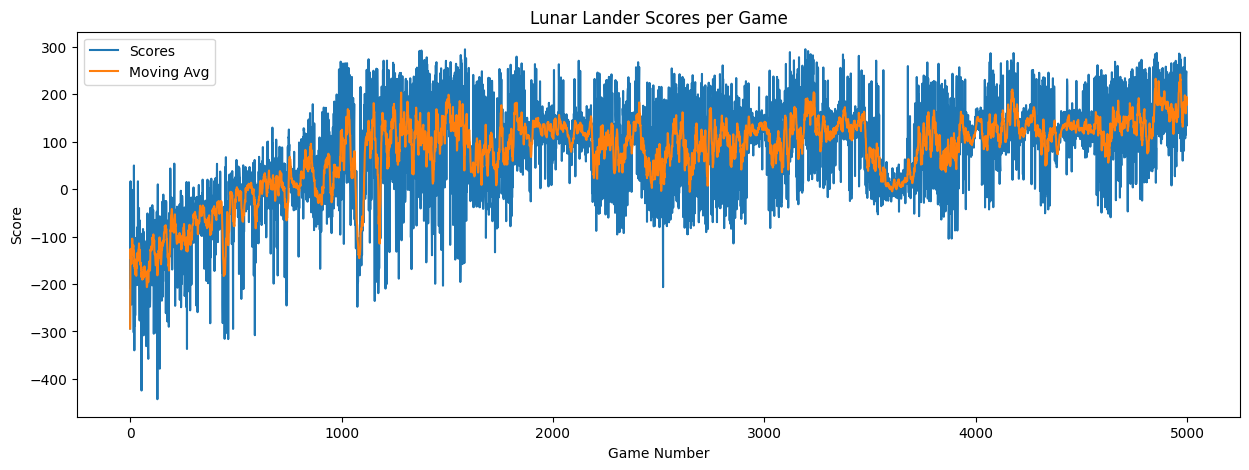

In [10]:
plt.figure(figsize=(15,5))
plt.plot(log["scores"], label="Scores")
plt.plot(log["running_avg_scores"], label="Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

### Lets Play the Game!

In [14]:
def record_game(env, policy, prefix, device="cuda"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset(seed=42)
    
    while not done:

        ### Get Predicted Action ###
        action = policy(torch.tensor(state, device=device).unsqueeze(0)).argmax(axis=-1).item()

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()

record_game(env, policy, prefix="policy-network")

Video("savevideos/policy-network-episode-0.mp4", embed=True)

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Deep RL Policy Models/policy_networks/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
